#### Implementation of InceptionResNetV2 for classification of skin lesions using the MNIST-HAM10000 Dataset.
- Date : January 23rd 2024
- Author : Aarya Bhave
- Project : Skin_Cancer_Diagnosis
  
This code carries out transfer-learning on the InceptionResNetV2 Model for classification of seven types of skin lesions.  
Before running this file locally, you must have Tensorflow-GPU installed with a dedicated GPU.
 

In [28]:
#IMPORT LIBRARIES :
import tensorflow as tf 
import keras as K 
import matplotlib.pyplot as plt 
import seaborn as sns
import cv2
import numpy as np
import pandas as pd
import sklearn

##### Compute class weight for handling the skew.

In [29]:
#Load the Meta Data
meta_data = pd.read_csv('data/HAM10000_metadata.csv')
labels = meta_data['dx']

#Compute and process class weights
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(labels),
                                                 y=labels)
class_weight_dictionary = dict(enumerate(class_weights))
class_weight_dictionary

{0: 4.375273044997815,
 1: 2.78349082823791,
 2: 1.301832835044846,
 3: 12.440993788819876,
 4: 1.2854575792581184,
 5: 0.21338020666879728,
 6: 10.075452716297788}

##### Set up ImageDataGenerator and the loader objects

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input as base_preprocess

#Setup generator.
image_gen = ImageDataGenerator(
                               preprocessing_function=base_preprocess,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               # rescale=1/255,
                               validation_split=0.15)

data_dir = 'data/reorganized'
batch_size = 64
target_size = (224,224)

#Setup loaders.
train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


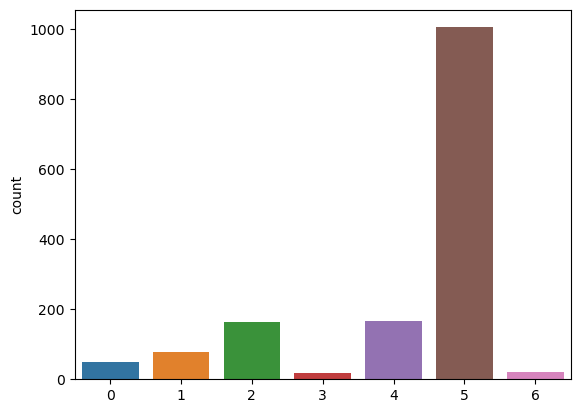

In [31]:
#Test-Set skew.
sns.countplot(x=test_image_gen.classes)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


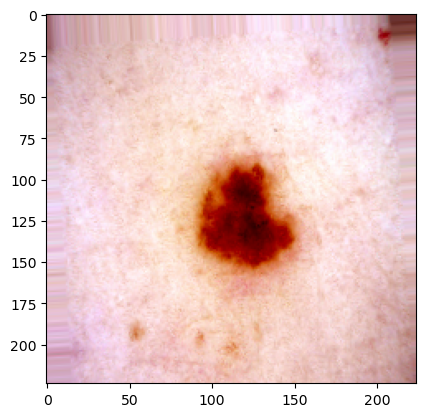

In [32]:
#Checkout a picture
plt.imshow(train_image_gen[0][0][0])
plt.show()

##### Create the trainable InceptionResNetV2 Model
- _InceptionResNetV2 Base_  

- _GlobalAveragePooling2D Layer_  
- _Regularized Dense Layer_  
- _Dropout Layer_  
- _Output Dense Layer_  

In [33]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
incres_model = Model(inputs=base_model.input, outputs=x)


incres_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_609 (Conv2D)         (None, 111, 111, 32)         864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_609 (B  (None, 111, 111, 32)         96        ['conv2d_609[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_609 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_60

In [34]:
optimizer = Adam(0.0001)
incres_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

### **MODEL TRAINING**
- Train only when on a power supply.
- Use performance power mode.

In [35]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_dn121.hdf5',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [36]:
history = incres_model.fit(train_image_gen,
                       epochs=15, 
                       validation_data = test_image_gen,
                       class_weight=class_weight_dictionary,
                       callbacks=callback_list)

Epoch 1/15


2024-01-24 00:29:23.941762: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.59MiB (rounded to 1671168)requested by op model_3/block17_15_conv/Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-01-24 00:29:23.941878: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-01-24 00:29:23.941892: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 1124, Chunks in use: 1124. 281.0KiB allocated for chunks. 281.0KiB in use in bin. 164.3KiB client-requested in use in bin.
2024-01-24 00:29:23.941902: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 1339, Chunks in use: 1339. 916.0KiB allocated for chunks. 916.0KiB in use in bin. 875.9KiB client-requested in

ResourceExhaustedError: Graph execution error:

Detected at node model_3/block17_15_conv/Conv2D defined at (most recent call last):
  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_51880/1280369545.py", line 1, in <module>

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

OOM when allocating tensor with shape[1088,384,1,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_3/block17_15_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_154651]

In [ ]:
df=pd.DataFrame(incres_model.history.history)
df.to_csv('hist3.csv')